In [1]:
import requests
import pandas as pd
import nltk, re

In [2]:
# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shoibolina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1: Fetch Data from NYTimes API

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.environ.get("NYTIMES_API_KEY")

In [4]:
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
params = {
    "q": "politics",
    "api-key": api_key,
    "begin_date": "20250101",
    "end_date": "20250327"
}

In [5]:
r = requests.get(url, params=params)
data = r.json()

if "response" in data and "meta" in data["response"]:
    total_hits = data["response"]["meta"]["hits"]
    print("Total hits:", total_hits)
else:
    print("No 'response' or 'meta' in the data:", data)
    total_hits = 0

Total hits: 5585


In [6]:
import time
import pandas as pd

all_rows = []
page_size = 10  # Each page returns up to 10 articles
max_pages = (total_hits // page_size)
max_pages = min(max_pages, 10)

for page_num in range(max_pages + 1):
    print(f"Fetching page {page_num}...")
    params["page"] = page_num
    r = requests.get(url, params=params)
    
    # Check HTTP status
    if r.status_code != 200:
        print(f"Request failed with status code {r.status_code}")
        break
    
    data = r.json()
    
    # Check if 'response' is present
    if "response" not in data:
        print("No 'response' in data. Possibly an error:", data)
        break
    
    # Check if 'docs' is present under 'response'
    if "docs" not in data["response"]:
        print("No 'docs' in 'response':", data["response"].keys())
        break
    
    docs = data["response"]["docs"]
    if not docs:
        print("Empty 'docs' on page", page_num, " - stopping.")
        break
    
    # Extract desired fields
    for article in docs:
        all_rows.append({
            "headline": article.get("headline", {}).get("main"),
            "short_description": article.get("snippet"),
            "pub_date": article.get("pub_date"),
            "links": article.get("web_url")
        })
    
    # Sleep briefly to respect NYTimes rate limits
    time.sleep(10)

Fetching page 0...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...


In [7]:
df_nyt = pd.DataFrame(all_rows)
print("Total articles fetched:", df_nyt.shape[0])

Total articles fetched: 110


In [8]:
df_nyt

,headline,short_description,pub_date,links
0,"In a Sea of Political Change, Bernie Sanders K...",An aging star playing to massive crowds of sup...,2025-03-24T19:23:57+0000,https://www.nytimes.com/2025/03/24/style/berni...
1,"Money, Power and Politics: The Musk Effect in ...","Elon Musk is seemingly everywhere, dominating ...",2025-03-22T09:02:42+0000,https://www.nytimes.com/2025/03/22/us/politics...
2,Son of Jair Bolsonaro Says He Will Seek Politi...,"Eduardo Bolsonaro, a son of Brazil’s former pr...",2025-03-18T21:30:39+0000,https://www.nytimes.com/2025/03/18/world/ameri...
3,The Politics of Gratitude: How Trump Insists o...,It’s not unusual for presidents to want to hea...,2025-03-23T13:51:59+0000,https://www.nytimes.com/2025/03/23/us/politics...
4,"Mia Love, First Black Republican Woman Elected...","Ms. Love, from Utah, held a seat in the House ...",2025-03-24T06:07:51+0000,https://www.nytimes.com/2025/03/24/us/politics...
...,...,...,...,...
105,"As the Left Looks to 2028, It Waits on Ocasio-...",With Bernie Sanders unlikely to run for presid...,2025-03-23T09:01:59+0000,https://www.nytimes.com/2025/03/23/us/politics...
106,Will She or Won’t She? Retirement Hovers Over ...,Nancy Pelosi has represented San Francisco in ...,2025-03-23T09:00:39+0000,https://www.nytimes.com/2025/03/23/us/politics...
107,"It’s Trump vs. the Courts, and It Won’t End We...",The judiciary will never surrender to the pres...,2025-03-23T11:00:20+0000,https://www.nytimes.com/2025/03/23/opinion/tru...
108,"Canada, May I Introduce You to Ukraine?",We already know what happens when great powers...,2025-03-23T11:00:20+0000,https://www.nytimes.com/2025/03/23/opinion/tru...


## Step 2: Combine and Clean Text

In [9]:
# Combine headline and short_description to enrich text content
df_nyt['combined_text'] = df_nyt['headline'] + " " + df_nyt['short_description']

In [10]:
# Clean text function: lowercases, removes non-word characters, and drops stopwords
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

In [11]:
df_nyt['clean_text'] = df_nyt['combined_text'].apply(clean_text)

In [12]:
df_nyt.head()

,headline,short_description,pub_date,links,combined_text,clean_text
0,"In a Sea of Political Change, Bernie Sanders K...",An aging star playing to massive crowds of sup...,2025-03-24T19:23:57+0000,https://www.nytimes.com/2025/03/24/style/berni...,"In a Sea of Political Change, Bernie Sanders K...",sea political change bernie sanders keeps truc...
1,"Money, Power and Politics: The Musk Effect in ...","Elon Musk is seemingly everywhere, dominating ...",2025-03-22T09:02:42+0000,https://www.nytimes.com/2025/03/22/us/politics...,"Money, Power and Politics: The Musk Effect in ...",money power politics musk effect washington be...
2,Son of Jair Bolsonaro Says He Will Seek Politi...,"Eduardo Bolsonaro, a son of Brazil’s former pr...",2025-03-18T21:30:39+0000,https://www.nytimes.com/2025/03/18/world/ameri...,Son of Jair Bolsonaro Says He Will Seek Politi...,son jair bolsonaro says seek political asylum ...
3,The Politics of Gratitude: How Trump Insists o...,It’s not unusual for presidents to want to hea...,2025-03-23T13:51:59+0000,https://www.nytimes.com/2025/03/23/us/politics...,The Politics of Gratitude: How Trump Insists o...,politics gratitude trump insists thanks foreig...
4,"Mia Love, First Black Republican Woman Elected...","Ms. Love, from Utah, held a seat in the House ...",2025-03-24T06:07:51+0000,https://www.nytimes.com/2025/03/24/us/politics...,"Mia Love, First Black Republican Woman Elected...",mia love first black republican woman elected ...


In [13]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans

## Step 3: Named Entity Recognition (NER)

In [14]:
# Make sure spaCy's English model is installed (run: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")
def extract_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

In [15]:
df_nyt['entities'] = df_nyt['combined_text'].apply(extract_entities)
print("NER example:")
df_nyt['entities'].head()

NER example:


0                                        [PERSON, ORG]
1                    [ORG, GPE, PERSON, GPE, ORG, GPE]
2                              [GPE, PERSON, GPE, GPE]
3                                                [ORG]
4    [PERSON, ORG, ORG, CARDINAL, PERSON, GPE, ORG,...
Name: entities, dtype: object

## Step 4: Topic Modeling with NMF

In [16]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(df_nyt['clean_text'])

In [17]:
# Set number of topics (you can adjust n_components)
nmf = NMF(n_components=5, random_state=42)
nmf_topics = nmf.fit_transform(tfidf)

In [18]:
def get_topics(model, feature_names, n_top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
        print("Topic #{}: {}".format(idx + 1, ", ".join(top_words)))
    return topics

topics = get_topics(nmf, vectorizer.get_feature_names_out(), 10)

Topic #1: trump, president, political, tariffs, constitutional, american, wants, prize, comes, world
Topic #2: chat, group, officials, signal, journalist, plans, military, intelligence, secretary, defense
Topic #3: musk, elon, wisconsin, legal, million, billionaire, tesla, court, sales, race
Topic #4: judge, federal, order, executive, law, case, funding, trump, judiciary, khalil
Topic #5: administration, trump, democrats, new, biden, party, agency, powers, lead, times


## Step 5: Clustering with KMeans

In [19]:
km = KMeans(n_clusters=5, random_state=42)
km_labels = km.fit_predict(tfidf)
df_nyt['cluster'] = km_labels

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Step 6: Visualization - Word Clouds for Each Cluster

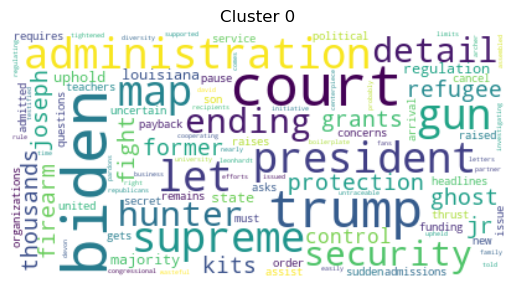

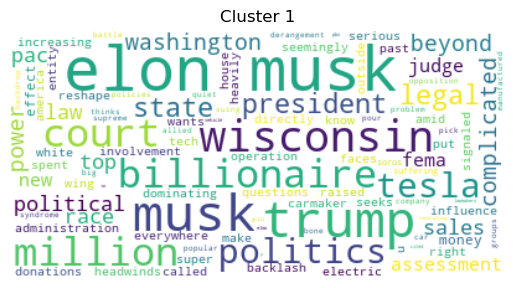

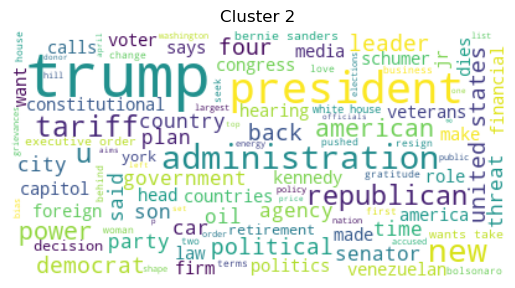

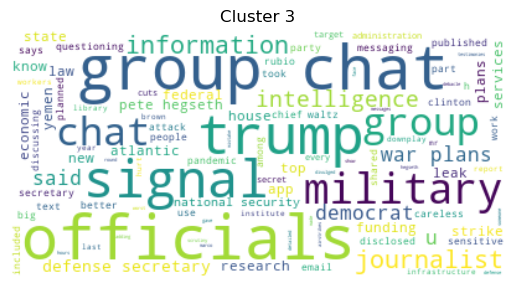

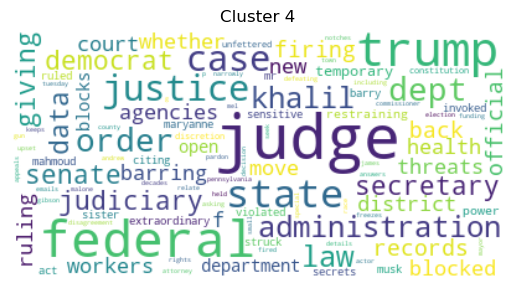

In [21]:
for i in range(5):
    cluster_text = ' '.join(df_nyt[df_nyt['cluster'] == i]['clean_text'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(cluster_text)
    plt.figure()
    plt.title("Cluster {}".format(i))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [22]:
import numpy as np
import seaborn as sns

In [23]:
df_nyt['dominant_topic'] = np.argmax(nmf_topics, axis=1)
df_nyt['dominant_topic']

0      0
1      2
2      0
3      4
4      0
      ..
105    4
106    4
107    0
108    4
109    4
Name: dominant_topic, Length: 110, dtype: int64

## Step 7: Parse Publication Date for Time-Series Analysis

In [24]:
# Convert the publication date to datetime and create a year-month column
df_nyt['pub_date'] = pd.to_datetime(df_nyt['pub_date'])
df_nyt['year_month'] = df_nyt['pub_date'].dt.to_period('M').astype(str)
print(df_nyt[['pub_date','year_month']].head())

                   pub_date year_month
0 2025-03-24 19:23:57+00:00    2025-03
1 2025-03-22 09:02:42+00:00    2025-03
2 2025-03-18 21:30:39+00:00    2025-03
3 2025-03-23 13:51:59+00:00    2025-03
4 2025-03-24 06:07:51+00:00    2025-03


/var/folders/3d/x2cy9zv54njcy99gp4szf1l00000gn/T/ipykernel_99566/1323155611.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_nyt['year_month'] = df_nyt['pub_date'].dt.to_period('M').astype(str)


In [25]:
df_nyt[['pub_date','year_month']]

,pub_date,year_month
0,2025-03-24 19:23:57+00:00,2025-03
1,2025-03-22 09:02:42+00:00,2025-03
2,2025-03-18 21:30:39+00:00,2025-03
3,2025-03-23 13:51:59+00:00,2025-03
4,2025-03-24 06:07:51+00:00,2025-03
...,...,...
105,2025-03-23 09:01:59+00:00,2025-03
106,2025-03-23 09:00:39+00:00,2025-03
107,2025-03-23 11:00:20+00:00,2025-03
108,2025-03-23 11:00:20+00:00,2025-03


## Step 8: Visualizations

In [26]:
def extract_topic_words(model, feature_names, n_top_words=3):
    """
    Returns a list of string labels, each label made by joining
    the top 'n_top_words' for that topic.
    """
    labels = []
    for idx, topic in enumerate(model.components_):
        # Get indices of top words in descending order
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        # Extract the corresponding words
        top_words = [feature_names[i] for i in top_indices]
        # Create a label like "president trump politics"
        labels.append(" ".join(top_words))
    return labels


In [27]:
feature_names = vectorizer.get_feature_names_out()
topic_labels = extract_topic_words(nmf, feature_names, n_top_words=3)
topic_labels

['trump president political',
 'chat group officials',
 'musk elon wisconsin',
 'judge federal order',
 'administration trump democrats']

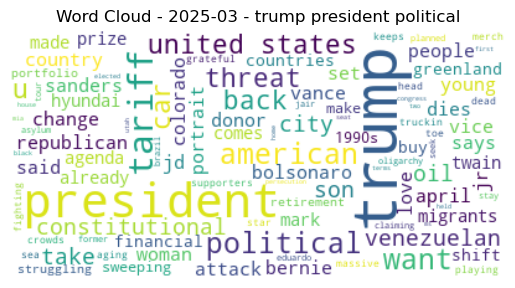

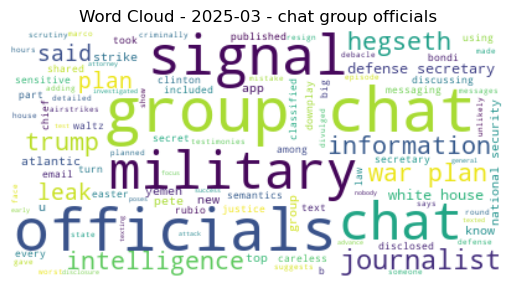

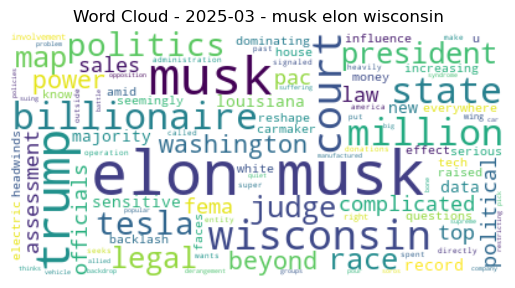

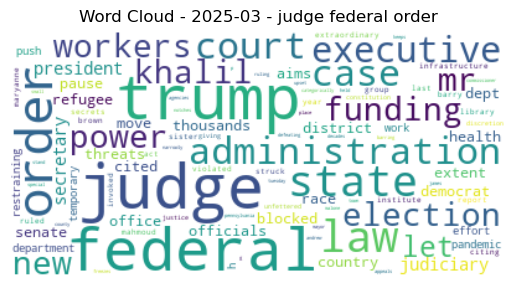

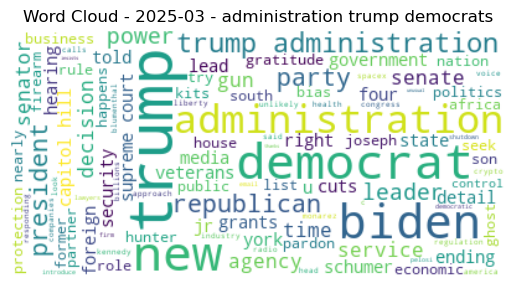

In [28]:
# Generate word clouds for each topic within a specific time period
for ym in df_nyt['year_month'].unique():
    subset = df_nyt[df_nyt['year_month'] == ym]
    for topic_idx in range(len(topic_labels)):
        # Filter rows for this topic
        topic_text = ' '.join(subset[subset['dominant_topic'] == topic_idx]['clean_text'])
        if topic_text.strip():
            wordcloud = WordCloud(
                max_font_size=50, max_words=100, background_color='white'
            ).generate(topic_text)
            
            # Use your custom label
            plt.figure()
            plt.title(f"Word Cloud - {ym} - {topic_labels[topic_idx]}")
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()
